In [1]:
import numpy as np
import pandas as pd 
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv(r"C:\Users\admin\OneDrive\Documents\weather_data.csv")
df.set_index('Date').sort_index()

columns_of_interest = ['TempAvgF','DewPointAvgF', 'HumidityAvgPercent', 'SeaLevelPressureAvgInches', 'VisibilityAvgMiles', 'WindAvgMPH', 'PrecipitationSumInches']
data = df[columns_of_interest]
events = df[['Events']].replace(' ', 'None')

Xem qua thành phần của bộ dữ liệu chúng ta sẽ dùng để phân tích

In [7]:
data

,TempAvgF,DewPointAvgF,HumidityAvgPercent,SeaLevelPressureAvgInches,VisibilityAvgMiles,WindAvgMPH,PrecipitationSumInches
0,60,49,75,29.68,7,4,0.46
1,48,36,68,30.13,10,6,0
2,45,27,52,30.49,10,3,0
3,46,28,56,30.45,10,4,0
4,50,40,71,30.33,10,2,T
...,...,...,...,...,...,...,...
1314,89,67,54,29.97,10,5,0
1315,91,64,54,29.9,10,5,0
1316,92,64,51,29.86,10,4,0
1317,93,68,48,29.91,10,4,0


Vẽ đồ thị thể hiện số lượng các sự kiện thời tiết đã xảy ra trong bộ dữ liệu

<Axes: >

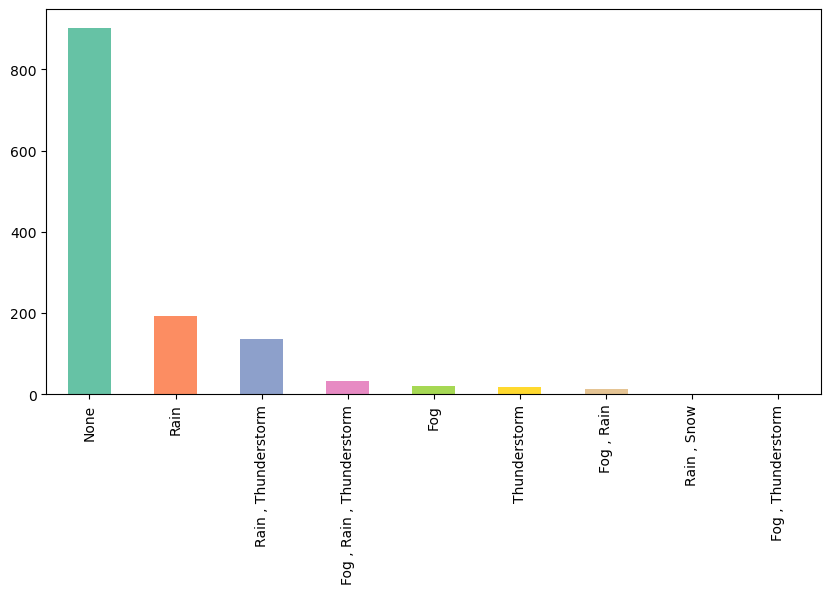

In [5]:
events.Events.value_counts().plot(kind='bar', figsize=(10,5), color = plt.cm.Set2(range(len(events.Events.unique()))))

Lọc ra những sự kiện thời tiết đơn lẻ

In [8]:
unique_events = set()
for value in events.Events.value_counts().index:
    splitted = [x.strip() for x in value.split(',')]
    unique_events.update(splitted)
unique_events

{'Fog', 'None', 'Rain', 'Snow', 'Thunderstorm'}

Gán giá trị True cho các sự kiện thời tiết xảy ra tương ứng với từng hàng, ngược lại thì False

In [9]:
single_events = pd.DataFrame()
for event_type in unique_events:
    event_occurred = events.Events.str.contains(event_type)
    single_events = pd.concat([single_events, pd.DataFrame(data={event_type: event_occurred.values})], join='outer', axis=1)
single_events

,Thunderstorm,Rain,Snow,Fog,None
0,True,True,False,False,False
1,False,False,False,False,True
2,False,False,False,False,True
3,False,False,False,False,True
4,False,False,False,False,True
...,...,...,...,...,...
1314,False,False,False,False,True
1315,False,False,False,False,True
1316,False,False,False,False,True
1317,False,False,False,False,True


Vẽ đồ thị thể hiện số lượng của từng sự kiện thời tiết riêng lẻ trong bộ dữ liệu

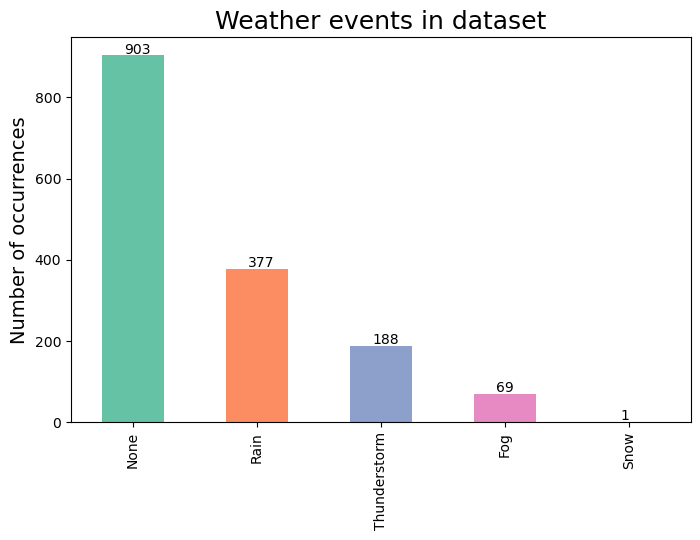

In [10]:
ax = single_events.sum().sort_values(ascending=False).plot.bar(figsize=(8,5), color = plt.cm.Set2(range(len(events.Events.unique()))))
ax.set_title("Weather events in dataset", fontsize=18)
ax.set_ylabel("Number of occurrences", fontsize=14)
for i in ax.patches:
    ax.text(i.get_x()+.18, i.get_height()+5, i.get_height(), fontsize=10)

Trong bộ dữ liệu đang sử dụng, có thể thấy ở cột PrecipitationSumInches có các giá trị T bên cạnh những số cụ thể.
Điều này có thể hiểu là vào ngày hôm đó có mưa nhưng không biết cụ thể là bao nhiêu.

In [12]:
precipitation = data[pd.to_numeric(data.PrecipitationSumInches, errors='coerce').isnull()].PrecipitationSumInches.value_counts()
precipitation

T    124
Name: PrecipitationSumInches, dtype: int64

Kiểm tra xem bộ dữ liệu được sử dụng có bao nhiêu hàng không phải là số.

In [13]:
def isColumnNotNumeric(columns_of_interest, data):
    result = np.zeros(data.shape[0], dtype=bool)
    for column_name in columns_of_interest:
        result = result | pd.to_numeric(data[column_name], errors='coerce').isnull()
    return result

def getDataFrameWithNonNumericRows(dataFrame):
    return data[isColumnNotNumeric(columns_of_interest, data)]

non_numeric_rows_count = getDataFrameWithNonNumericRows(data).shape[0]

print("Non numeric rows: {0}".format(non_numeric_rows_count))

Non numeric rows: 134


Chuyển đổi các dòng có T trong cột PrecipitationSumInches thành số 0.
Đồng thời, tạo một cột mới tên PrecipitationTrace để lưu trữ các giả trị T này (gán 1 cho những dòng có T, 0 cho những dòng còn lại)

In [14]:
def numberOrZero(value):
    try:
        parsed = float(value)
        return parsed
    except:
        return 0

#Find rows indices with "T" values
has_precipitation_trace_series = isColumnNotNumeric(['PrecipitationSumInches'], data).astype(int)
data = data.assign(PrecipitationTrace=has_precipitation_trace_series.values)
data['PrecipitationSumInches'] = data['PrecipitationSumInches'].apply(numberOrZero)
data.iloc[0:10,:]

,TempAvgF,DewPointAvgF,HumidityAvgPercent,SeaLevelPressureAvgInches,VisibilityAvgMiles,WindAvgMPH,PrecipitationSumInches,PrecipitationTrace
0,60,49,75,29.68,7,4,0.46,0
1,48,36,68,30.13,10,6,0.00,0
2,45,27,52,30.49,10,3,0.00,0
3,46,28,56,30.45,10,4,0.00,0
4,50,40,71,30.33,10,2,0.00,1
5,48,36,63,30.4,9,3,0.00,0
6,53,39,65,30.39,9,1,0.00,1
7,51,39,64,30.17,10,2,0.00,1
8,50,41,76,30.1,10,5,0.00,0
9,40,26,60,30.33,10,5,0.00,0


Từ các output trên, có thể thấy, ngoài cột T thì có nhiều cột khác chứa giá trị không phải số và đã được chuyển thành null.
Vì thế, phải cân nhắc xử lí để mô hình chạy hiệu quả.

In [16]:
getDataFrameWithNonNumericRows(data)

,TempAvgF,DewPointAvgF,HumidityAvgPercent,SeaLevelPressureAvgInches,VisibilityAvgMiles,WindAvgMPH,PrecipitationSumInches,PrecipitationTrace
174,79,-,75,29.95,-,4,0.0,0
175,92,-,77,29.93,-,6,0.0,0
176,83,-,-,29.9,-,9,0.0,0
177,84,-,72,29.99,-,8,0.0,1
596,89,-,65,-,-,-,0.0,0
597,90,-,62,-,-,6,0.0,0
598,90,-,-,-,-,-,0.0,0
638,82,63,60,29.96,-,3,0.0,0
639,84,64,57,29.95,-,4,0.0,0
741,46,33,60,30.48,-,8,0.0,1


In [17]:
row_indices_for_missing_values = getDataFrameWithNonNumericRows(data).index.values
data_prepared = data.drop(row_indices_for_missing_values)
events_prepared = single_events.drop(row_indices_for_missing_values)
print("Data rows: {0}, Events rows: {1}".format(data_prepared.shape[0], events_prepared.shape[0]))

Data rows: 1307, Events rows: 1307


Vì mô hình của học máy không giám sát nhóm sử dụng được chạy trên các dữ liệu dạng số.
Vì thế, phải kiểm tra xem loại dữ liệu của các cột và ép kiểu nếu cần.

In [18]:
data_prepared.dtypes

TempAvgF                       int64
DewPointAvgF                  object
HumidityAvgPercent            object
SeaLevelPressureAvgInches     object
VisibilityAvgMiles            object
WindAvgMPH                    object
PrecipitationSumInches       float64
PrecipitationTrace             int32
dtype: object

In [19]:
data_prepared = data_prepared.apply(pd.to_numeric)
data_prepared.dtypes

TempAvgF                       int64
DewPointAvgF                   int64
HumidityAvgPercent             int64
SeaLevelPressureAvgInches    float64
VisibilityAvgMiles             int64
WindAvgMPH                     int64
PrecipitationSumInches       float64
PrecipitationTrace             int32
dtype: object

Bắt đầu chuẩn hóa dữ liệu để huấn luyện mô hình

In [20]:
from sklearn import preprocessing
data_values = data_prepared.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()

data_prepared = pd.DataFrame(min_max_scaler.fit_transform(data_prepared), columns=data_prepared.columns, index=data_prepared.index)

In [21]:
data_prepared.head()

,TempAvgF,DewPointAvgF,HumidityAvgPercent,SeaLevelPressureAvgInches,VisibilityAvgMiles,WindAvgMPH,PrecipitationSumInches,PrecipitationTrace
0,0.484375,0.602941,0.685714,0.109244,0.625,0.272727,0.088462,0.0
1,0.296875,0.411765,0.585714,0.487395,1.000,0.454545,0.000000,0.0
2,0.250000,0.279412,0.357143,0.789916,1.000,0.181818,0.000000,0.0
3,0.265625,0.294118,0.414286,0.756303,1.000,0.272727,0.000000,0.0
4,0.328125,0.470588,0.628571,0.655462,1.000,0.090909,0.000000,1.0


In [22]:
events_prepared.head()

,Thunderstorm,Rain,Snow,Fog,None
0,True,True,False,False,False
1,False,False,False,False,True
2,False,False,False,False,True
3,False,False,False,False,True
4,False,False,False,False,True


Chia dữ liệu thành 2 tập riêng biệt để huấn luyện và kiểm thử

In [24]:
from sklearn.model_selection import train_test_split

random_state = 42
X_train, X_test = train_test_split(data_prepared, test_size=0.2, random_state=random_state)
y_train, y_test = train_test_split(events_prepared, test_size=0.2, random_state=random_state)

clusters_count = len(unique_events)
X_train

,TempAvgF,DewPointAvgF,HumidityAvgPercent,SeaLevelPressureAvgInches,VisibilityAvgMiles,WindAvgMPH,PrecipitationSumInches,PrecipitationTrace
1304,0.921875,0.926471,0.514286,0.294118,1.000,0.181818,0.000000,1.0
547,0.781250,0.985294,0.828571,0.403361,0.625,0.272727,0.178846,0.0
293,0.859375,0.911765,0.557143,0.285714,1.000,0.545455,0.000000,0.0
10,0.265625,0.294118,0.385714,0.705882,1.000,0.000000,0.000000,0.0
147,0.687500,0.691176,0.442857,0.352941,1.000,0.727273,0.000000,0.0
...,...,...,...,...,...,...,...,...
1107,0.531250,0.647059,0.671429,0.252101,0.750,0.090909,0.000000,0.0
1142,0.515625,0.750000,0.885714,0.428571,0.500,0.181818,0.000000,1.0
1306,0.937500,0.911765,0.471429,0.436975,1.000,0.363636,0.000000,0.0
871,0.781250,0.911765,0.685714,0.268908,0.500,0.636364,0.051923,0.0


Sử dụng những thuật toán phân cụm và so sánh với kết quả thực tế. Từ đó, đưa ra thuật toán cho kết quả gần với thực tế nhất.

<Axes: >

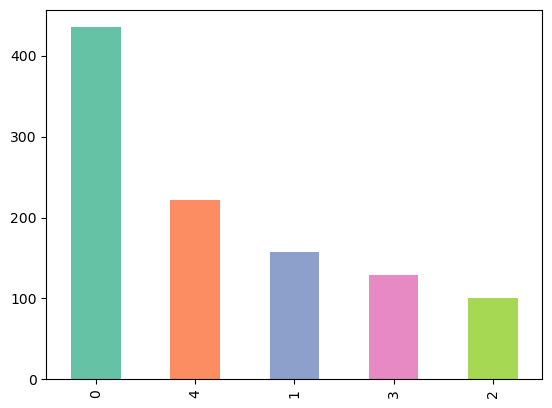

In [25]:
from sklearn.cluster import KMeans
warnings.filterwarnings("ignore")
kmeans = KMeans(n_clusters=clusters_count).fit(X_train)

resultDf = pd.DataFrame(kmeans.labels_)
resultDf.iloc[:,0].value_counts().plot.bar(color = plt.cm.Set2(range(len(events.Events.unique()))))
#plt.hist(kmeans.labels_)

<Axes: >

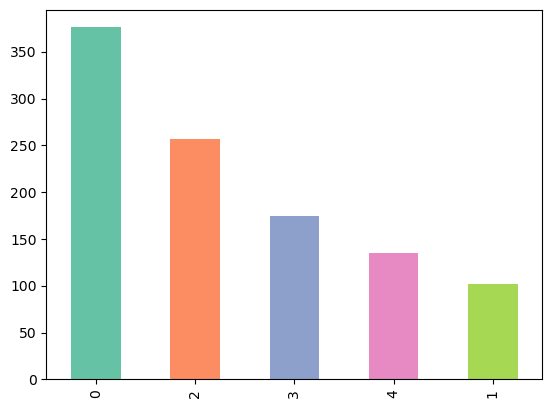

In [26]:
from sklearn.cluster import SpectralClustering
warnings.filterwarnings("ignore")
sc = SpectralClustering(n_clusters=clusters_count).fit(X_train)
resultDf2 = pd.DataFrame(sc.labels_)
resultDf2.iloc[:,0].value_counts().plot.bar(color = plt.cm.Set2(range(len(events.Events.unique()))))

<Axes: >

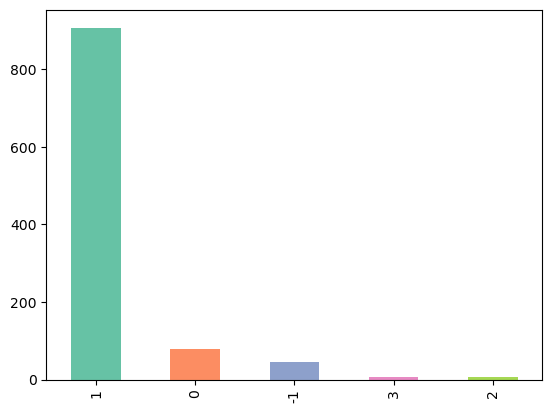

In [27]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.25, min_samples=4).fit(X_train)
resultDf = pd.DataFrame(dbscan.labels_)
resultDf.iloc[:,0].value_counts().plot.bar(color = plt.cm.Set2(range(len(events.Events.unique()))))

<Axes: >

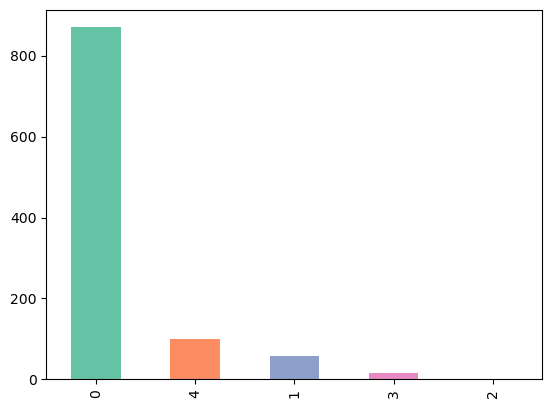

In [28]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=clusters_count, linkage="average").fit(X_train)
resultDf = pd.DataFrame(ac.labels_)
resultDf.iloc[:,0].value_counts().plot.bar(color = plt.cm.Set2(range(len(events.Events.unique()))))

<Axes: >

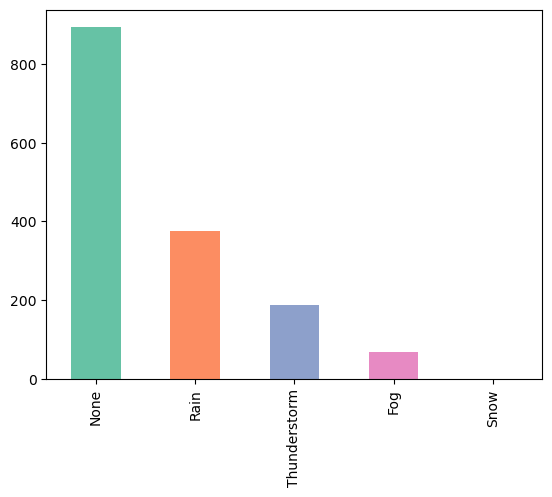

In [29]:
events_prepared.sum().sort_values(ascending=False).plot.bar(color = plt.cm.Set2(range(len(events.Events.unique()))))

Có thể thấy, thuật toán phân cụm Agglomerative đem lại kết quả phân cụm gần với thực tế nhất.

<Axes: title={'center': 'Bar obtained from agglomerative clustering'}>

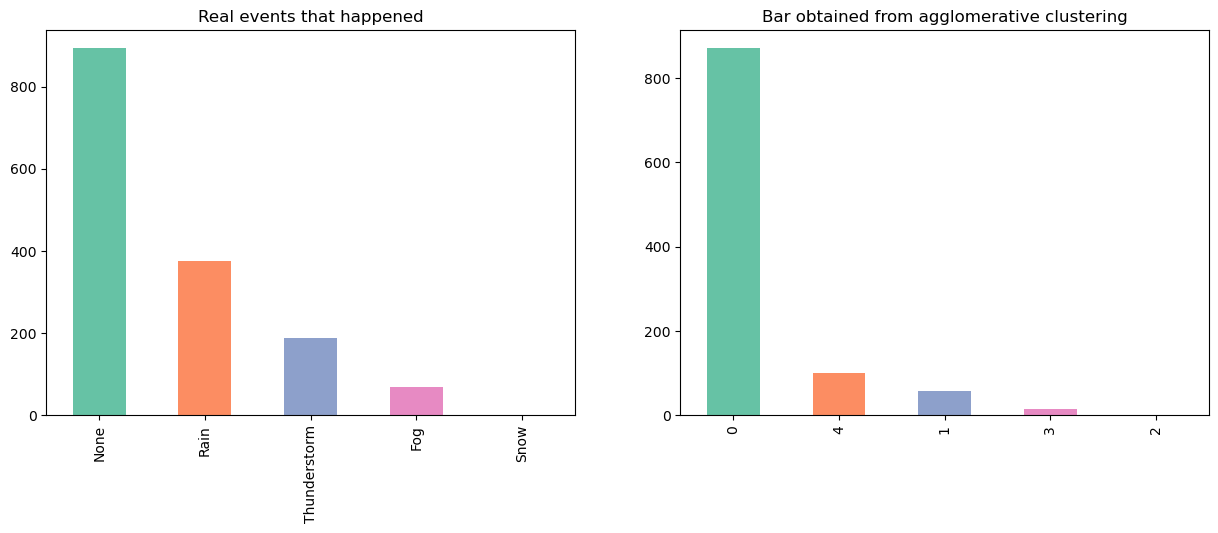

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
events_prepared.sum().sort_values(ascending=False).plot.bar(ax=ax[0], title="Real events that happened", color = plt.cm.Set2(range(len(events.Events.unique()))))
resultDf.iloc[:,0].value_counts().plot.bar(ax=ax[1], title="Bar obtained from agglomerative clustering", color = plt.cm.Set2(range(len(events.Events.unique()))))

Thực hiện gán tên cụm vào tên sự kiện thời tiết tương ứng. 
Sau đó, sử dụng lý thuyết phân cụm của thuật toán Agglomerative để xem rằng liệu 1 ngày có thể có 2 sự kiện thời tiết hay không.

In [32]:
event_names_ordered = events_prepared.sum().sort_values(ascending=False).index
clusters_ordered = resultDf.iloc[:,0].value_counts().index
cluster_category_mapping = {}
for i in range(clusters_count):
    cluster_category_mapping.update({clusters_ordered[i]:event_names_ordered[i]})
cluster_category_mapping


{0: 'None', 4: 'Rain', 1: 'Thunderstorm', 3: 'Fog', 2: 'Snow'}

In [34]:
data

,TempAvgF,DewPointAvgF,HumidityAvgPercent,SeaLevelPressureAvgInches,VisibilityAvgMiles,WindAvgMPH,PrecipitationSumInches,PrecipitationTrace
0,60,49,75,29.68,7,4,0.46,0
1,48,36,68,30.13,10,6,0.00,0
2,45,27,52,30.49,10,3,0.00,0
3,46,28,56,30.45,10,4,0.00,0
4,50,40,71,30.33,10,2,0.00,1
...,...,...,...,...,...,...,...,...
1314,89,67,54,29.97,10,5,0.00,0
1315,91,64,54,29.9,10,5,0.00,0
1316,92,64,51,29.86,10,4,0.00,0
1317,93,68,48,29.91,10,4,0.00,0


In [33]:
#tọa độ tâm từng cụm
cluster_centers_mapping = {}
for key in cluster_category_mapping:
    cluster_indices = resultDf.loc[resultDf[0] == key].index
    cluster_data = X_train.iloc[cluster_indices]
    mean = cluster_data.mean(axis=0).values
    #print("\n" + cluster_category_mapping[key])
    #print(mean)
    cluster_centers_mapping.update({key:mean})
cluster_centers_mapping

{0: array([0.66684626, 0.71558485, 0.53737274, 0.39408867, 0.92715517,
        0.36185998, 0.01333112, 0.        ]),
 4: array([0.66259282, 0.7603378 , 0.62192362, 0.39995008, 0.9220297 ,
        0.39423942, 0.        , 1.        ]),
 1: array([0.37553879, 0.59077079, 0.81453202, 0.46479281, 0.47844828,
        0.40125392, 0.06999337, 0.        ]),
 3: array([0.690625  , 0.88431373, 0.85142857, 0.28403361, 0.46666667,
        0.44242424, 0.59641026, 0.        ]),
 2: array([0.015625  , 0.05882353, 0.3       , 0.83193277, 1.        ,
        0.36363636, 0.        , 1.        ])}

In [36]:
#tính khoảng cách từ 1 điểm đến tâm từng cụm
def get_distances_from_cluster(data_frame):
    cluster_distance = np.zeros((data_frame.shape[0], clusters_count))
    #khoảng cách euclidean
    for i in range(data_frame.shape[0]):
        for key in cluster_category_mapping:
            dist = np.linalg.norm(data_frame.iloc[[i]].values[0]-cluster_centers_mapping[key])
            cluster_distance[i,key] = dist
            #print(dist)
    column_names = [cluster_category_mapping[k] for k in cluster_category_mapping]
    #column_names

    return pd.DataFrame(cluster_distance, index=data_frame.index, columns=column_names)

distancesDf = get_distances_from_cluster(X_train)
distancesDf

,None,Rain,Thunderstorm,Fog,Snow
1304,1.076076,1.362176,1.393672,1.370068,0.410872
547,0.545300,0.611610,1.757403,0.511271,1.114620
293,0.356203,0.856249,1.684327,0.875558,1.052542
10,0.771528,0.883183,1.128419,1.326534,1.298398
147,0.388148,0.800786,1.494443,0.964510,1.075485
...,...,...,...,...,...
1107,0.407664,0.517768,1.490951,0.821374,1.084434
1142,1.166892,1.051129,1.231481,1.222892,0.561554
1306,0.351305,0.903140,1.662150,0.935868,1.062798
871,0.590384,0.615363,1.762538,0.609792,1.139158


In [38]:
def classify_events(distances_dataFrame):
    return distances_dataFrame.apply(lambda x: x<x.min()*1.01, axis=1)

classification_result = classify_events(distancesDf)
X_train_col_ordered = classification_result.reindex(sorted(classification_result.columns), axis=1)
y_train_col_ordered = y_train.reindex(sorted(y_train.columns), axis=1)

#xem giá trị  dự đoán có đúng vs gtri thực tế
def check_accuracy(X, y):    
    comparison = X == y
    val_counts = comparison.all(axis=1).value_counts()
    percentageCorrect = val_counts.at[True] / X.shape[0] * 100
    return percentageCorrect

Đánh giá mô hình phân cụm dựa trên tỷ lệ giữa số dòng dự báo đúng và tổng số dòng của 2 tập X_train và X_test

In [39]:
check_accuracy(X_train_col_ordered, y_train_col_ordered)

64.97607655502392

In [40]:
X_train_col_ordered.head()

,Fog,None,Rain,Snow,Thunderstorm
1304,False,False,False,True,False
547,True,False,False,False,False
293,False,True,False,False,False
10,False,True,False,False,False
147,False,True,False,False,False


In [41]:
y_train_col_ordered.head()

,Fog,None,Rain,Snow,Thunderstorm
1304,False,False,True,False,True
547,True,False,True,False,True
293,False,True,False,False,False
10,False,True,False,False,False
147,False,True,False,False,False


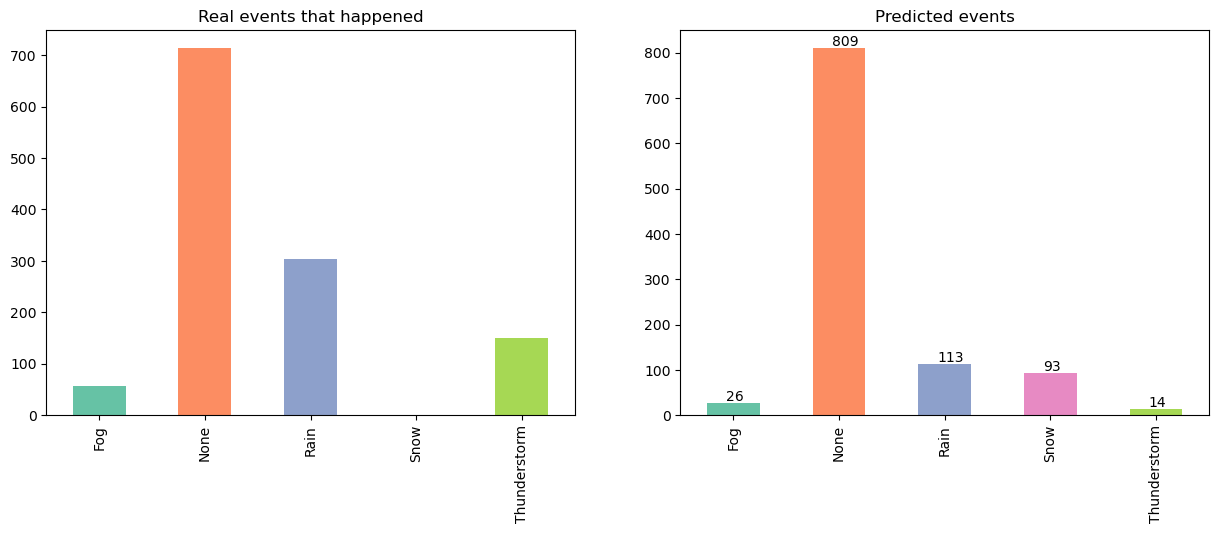

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
y_train_col_ordered.sum().plot.bar(ax=ax[0], title="Real events that happened", color = plt.cm.Set2(range(len(events.Events.unique()))))
ax = X_train_col_ordered.sum().plot.bar(ax=ax[1], title="Predicted events", color = plt.cm.Set2(range(len(events.Events.unique()))))
#resultDf.iloc[:,0].value_counts().plot.bar(ax=ax[1], title="Histogram obtained from agglomerative clustering")
for i in ax.patches:
    ax.text(i.get_x()+.18, i.get_height()+5, i.get_height(), fontsize=10)

<Axes: title={'center': 'Predicted events'}>

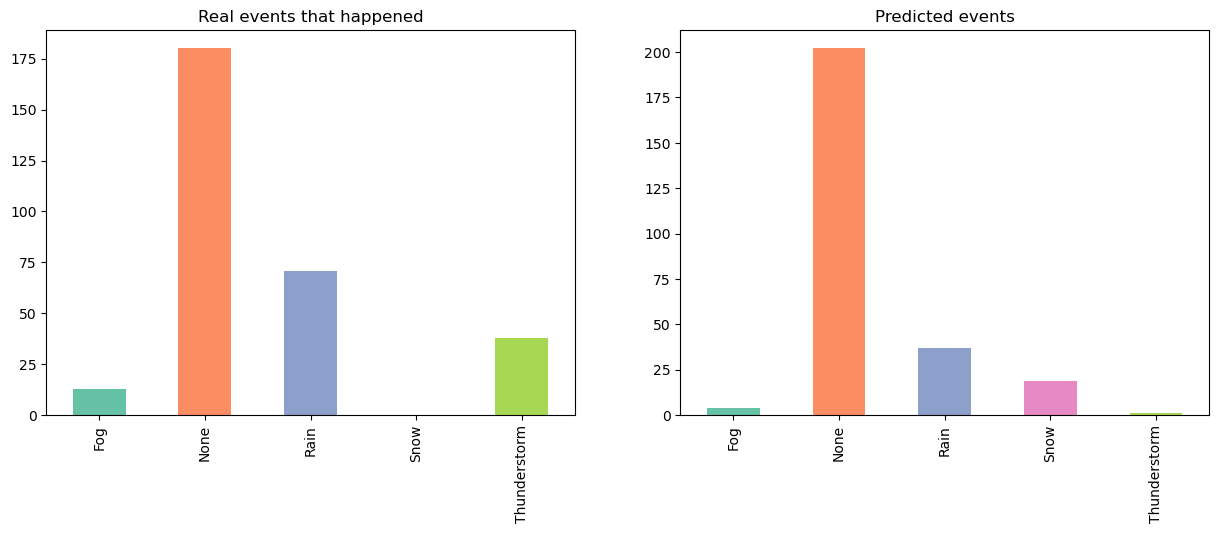

In [43]:
distancesDf = get_distances_from_cluster(X_test)
classification_result = classify_events(distancesDf)
X_test_col_ordered = classification_result.reindex(sorted(classification_result.columns), axis=1)
y_test_col_ordered = y_test.reindex(sorted(y_train.columns), axis=1)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
y_test_col_ordered.sum().plot.bar(ax=ax[0], title="Real events that happened", color = plt.cm.Set2(range(len(events.Events.unique()))))
X_test_col_ordered.sum().plot.bar(ax=ax[1], title="Predicted events", color = plt.cm.Set2(range(len(events.Events.unique()))))

In [44]:
check_accuracy(X_test_col_ordered, y_test_col_ordered)

70.22900763358778